#  Recommending movie with Movie lens data

In [11]:
#! wget  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip -O /home/nikhil/data/movielens.zip
#!unzip /home/nikhil/data/movielens.zip

In [12]:
!ls /home/nikhil/data/

dogscats  dogscats.zip	ml-latest-small  movielens


In [13]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [17]:
import sys,os
sys.path.append('/home/nikhil/fastai/')

In [18]:
import torch
from fastai.learner import *
from fastai.column_data import *

In [22]:
PATH = '/home/nikhil/data/ml-latest-small/'
ratings = pd.read_csv(PATH + 'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


# Visualize the data in tabular format

In [25]:
g=ratings.groupby('userId')['rating'].count()
type(g), g

(pandas.core.series.Series, userId
 1        20
 2        76
 3        51
 4       204
 5       100
 6        44
 7        88
 8       116
 9        45
 10       46
 11       38
 12       61
 13       53
 14       20
 15     1700
 16       29
 17      363
 18       51
 19      423
 20       98
 21      162
 22      220
 23      726
 24       21
 25       26
 26      172
 27       23
 28       50
 29       22
 30     1011
        ... 
 642      36
 643      24
 644      39
 645      30
 646     169
 647     150
 648     256
 649      90
 650      29
 651      20
 652     267
 653      51
 654     626
 655     105
 656     128
 657      20
 658      60
 659     142
 660      92
 661      33
 662      58
 663      26
 664     519
 665     434
 666      40
 667      68
 668      20
 669      37
 670      31
 671     115
 Name: rating, Length: 671, dtype: int64)

In [27]:
topUsers = g.sort_values(ascending=False)[:15]
topUsers


userId
547    2391
564    1868
624    1735
15     1700
73     1610
452    1340
468    1291
380    1063
311    1019
30     1011
294     947
509     923
580     922
213     910
212     876
Name: rating, dtype: int64

In [30]:
g = ratings.groupby('movieId')['rating'].count()
topMovies = g.sort_values(ascending=False)[:15]

In [31]:
top_r = ratings.join(topUsers, rsuffix='_r', how="inner", on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how="inner", on='movieId')

In [35]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,110,260,296,318,356,480,527,589,593,608,1196,1198,1270,2571
userId,,,,,,,,,,,,,,,
15,2.0,3.0,5.0,5.0,2.0,1.0,3.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0
30,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,3.0
73,5.0,4.0,4.5,5.0,5.0,5.0,4.0,5.0,3.0,4.5,4.0,5.0,5.0,5.0,4.5
212,3.0,5.0,4.0,4.0,4.5,4.0,3.0,5.0,3.0,4.0,NaN,NaN,3.0,3.0,5.0
213,3.0,2.5,5.0,NaN,NaN,2.0,5.0,NaN,4.0,2.5,2.0,5.0,3.0,3.0,4.0
294,4.0,3.0,4.0,NaN,3.0,4.0,4.0,4.0,3.0,NaN,NaN,4.0,4.5,4.0,4.5
311,3.0,3.0,4.0,3.0,4.5,5.0,4.5,5.0,4.5,2.0,4.0,3.0,4.5,4.5,4.0
380,4.0,5.0,4.0,5.0,4.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,NaN,3.0,5.0
452,3.5,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,2.0


### We see the rating of user 15 to movie 1	110	260	296	 etc

We will create a collabarative filter with 'CollabFilterDataset.from_csv' for csv ata set

In [39]:
cf = CollabFilterDataset.from_csv(PATH, 'ratings.csv', 
                                  'userId', 'movieId', 'rating')

$$ wi←wi−η∂E/∂wi−ηλwi $$ −ηλwi is weight decay 
https://stats.stackexchange.com/questions/29130/difference-between-neural-net-weight-decay-and-learning-rate

In [42]:
val_idxs = get_cv_idxs(len(ratings))
wd = 2e-4 # weight decay. 
n_factors = 50

In [44]:
learn = cf.get_learner(n_factors, val_idxs, bs=64, opt_fn=optim.Adam)

In [48]:
learn.fit(lrs=1e-2, n_cycle=2, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                  
    0      0.768353   0.781383  
    1      0.761131   0.774961                                  
    2      0.554564   0.764098                                  



[array([0.7641])]

### lets predict

In [51]:
preds = learn.predict()
y = learn.data.val_y
preds, y

(array([2.44247, 3.90329, 3.24841, ..., 4.0243 , 3.58898, 3.9415 ], dtype=float32),
 array([3.5, 4. , 3. , ..., 4. , 4. , 3.5], dtype=float32))

/home/nikhil/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/nikhil/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


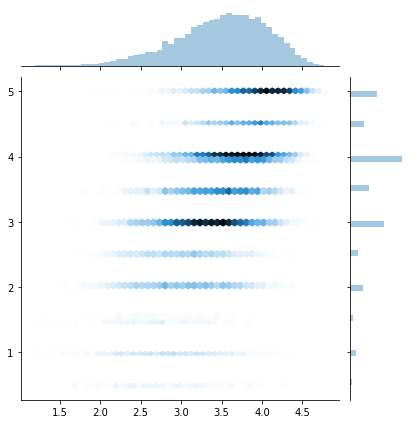

In [53]:
sns.jointplot(preds, y, kind='hex', stat_func=None)

### density of blue color shows the overlap of points. more overlap better prediction
https://www.meccanismocomplesso.org/en/hexagonal-binning/

In [54]:
movies = pd.read_csv(PATH + 'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [68]:
movie_names = movies.set_index('movieId')['title'].to_dict()

In [60]:
g = ratings.groupby('movieId')['rating'].count()
topMovies = g.sort_values(ascending=False).index.values[:3000]
topMovies

array([ 356,  296,  318, ...,  149, 1554,   72])

In [61]:
topMoviesIdx = np.array([cf.item2idx[o] for o in topMovies])

In [65]:
m=learn.model;
m.cuda()

EmbeddingDotBias(
  (u): Embedding(671, 50)
  (i): Embedding(9066, 50)
  (ub): Embedding(671, 1)
  (ib): Embedding(9066, 1)
)

In [69]:
movie_bias = to_np(m.ib(V(topMoviesIdx)))
movie_ratings = [(b[0], movie_names[i]) for i,b in zip(topMovies, movie_bias)]

### top rated movies

In [75]:
sorted(movie_ratings, key=itemgetter(0),reverse=True)[:15]

[(1.3366855, 'Shawshank Redemption, The (1994)'),
 (1.1491702, 'Godfather, The (1972)'),
 (1.0636046, 'Godfather: Part II, The (1974)'),
 (1.0204303, 'Usual Suspects, The (1995)'),
 (0.9576365, 'Fargo (1996)'),
 (0.9493932, "Schindler's List (1993)"),
 (0.91539466, 'Matrix, The (1999)'),
 (0.8903362, 'Silence of the Lambs, The (1991)'),
 (0.88541126, 'Citizen Kane (1941)'),
 (0.87268275, 'Pulp Fiction (1994)'),
 (0.86644727, 'Taxi Driver (1976)'),
 (0.8645798, 'Casablanca (1942)'),
 (0.86418873, '12 Angry Men (1957)'),
 (0.8576334, "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)"),
 (0.8567066, 'To Kill a Mockingbird (1962)')]

### worst rated movies

In [72]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-1.0745091, 'Battlefield Earth (2000)'),
 (-0.85190713, 'Wild Wild West (1999)'),
 (-0.83724654, 'Super Mario Bros. (1993)'),
 (-0.8053051, 'Anaconda (1997)'),
 (-0.786986, 'Speed 2: Cruise Control (1997)'),
 (-0.7835157, 'Superman III (1983)'),
 (-0.74627244, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.7335077, 'Bio-Dome (1996)'),
 (-0.72481084, 'Police Academy 4: Citizens on Patrol (1987)'),
 (-0.7221546, 'Batman & Robin (1997)'),
 (-0.7163475, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.71041685, 'Flintstones, The (1994)'),
 (-0.70238584, 'Congo (1995)'),
 (-0.701502, 'Inspector Gadget (1999)'),
 (-0.6877819, 'Message in a Bottle (1999)')]